In [23]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

In [24]:
sys.path.append('/Users/fllorente/Dropbox/con_Petar/PYTHON/gp_fusion')


In [25]:
from modules.model_training import train_and_predict_single_gp
from modules.fusion_methods import compute_neg_log_like
from modules.model_training import GPModel, to_torch, train_variational_gp, predict_variational_gp

import torch
from tqdm import tqdm

from gpytorch.means import ZeroMean
from gpytorch.kernels import AdditiveStructureKernel, RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.metrics import mean_standardized_log_loss

In [26]:
import imageio.v2 as imageio
import imageio as iio
 
X_train = []
# read an image 
for i in 1+np.arange(12000):
    img = iio.imread(f"/Users/fllorente/Downloads/datasets_without_preprocessing/face_images/face_images_train/{i}.jpg")
    X_train.append(img)

X_train = np.array(X_train)    
X_train = X_train.reshape(12000,28*28)
X_train.shape

/var/folders/b6/z4591_kn5dz7xy81wtgqr67c0000gp/T/ipykernel_66141/4241675017.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = iio.imread(f"/Users/fllorente/Downloads/datasets_without_preprocessing/face_images/face_images_train/{i}.jpg")


(12000, 784)

In [27]:
X_test = []
# read an image 
for i in 1+np.arange(800):
    img = iio.imread(f"/Users/fllorente/Downloads/datasets_without_preprocessing/face_images/face_images_test/{i}.jpg")
    X_test.append(img)

X_test = np.array(X_test)    
X_test = X_test.reshape(800,28*28)
X_test.shape

/var/folders/b6/z4591_kn5dz7xy81wtgqr67c0000gp/T/ipykernel_66141/236637803.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = iio.imread(f"/Users/fllorente/Downloads/datasets_without_preprocessing/face_images/face_images_test/{i}.jpg")


(800, 784)

In [28]:
# Normalize data
# X_train = X_train/255.0
# X_test = X_test/255.0

mean_x = np.mean(X_train,axis=0,keepdims=True)
std_x = np.std(X_train,axis=0,keepdims=True)

# X_train = X_train/255.0
# X_test = X_test/255.0

X_train = (X_train - mean_x)/std_x
X_test = (X_test - mean_x)/std_x

In [29]:
import pandas as pd

file = "/Users/fllorente/Downloads/datasets_without_preprocessing/face_images/face_images_train/train_list.txt"
df = pd.read_csv(file, header=None, delimiter=' ') # or quotechar = "'"
y_train = np.array(df[1])

file = "/Users/fllorente/Downloads/datasets_without_preprocessing/face_images/face_images_test/test_list.txt"
df = pd.read_csv(file, header=None, delimiter=' ') # or quotechar = "'"
y_test = np.array(df[1])

In [30]:
y_train.shape, y_test.shape
meanY = np.mean(y_train)
stdY = np.std(y_train)

In [31]:
# Normalize data
y_train = (y_train - meanY)/stdY
y_test = (y_test - meanY)/stdY

In [32]:
print(X_train.max(),X_test.max())
print(y_train.mean(), y_test.mean())
print(y_train.std(), y_test.std())

2.124092332765408 2.124092332765408
-7.105427357601002e-18 -0.011693234372475953
0.9999999999999999 1.0026059874361415


In [34]:
indices = np.random.choice(len(X_train),100)
X_train = X_train[indices]
y_train = y_train[indices]
len(X_train), len(y_train)

(100, 100)

In [35]:
from gpytorch.kernels import AdditiveStructureKernel, RBFKernel, ScaleKernel

# Fit a GP with ARD-RBF kernel as the baseline
inducing_points = X_train[:500]
kernel = AdditiveStructureKernel(base_kernel=ScaleKernel(RBFKernel()), 
                                             num_dims=X_train.shape[1])
model,likelihood = train_variational_gp(X_train, y_train, inducing_points, 
                                        learning_rate = 0.1, batch_size=128, num_epochs=5, 
                                        kappa=10, lambdaa = 5, kernel=kernel)

mean_tr,std_tr = predict_variational_gp(model, likelihood, X_train)
mean_tst,std_tst = predict_variational_gp(model, likelihood, X_test)


print("NLPD train: ", compute_neg_log_like(mean_tr,std_tr,y_train))
print("NLPD test: ", compute_neg_log_like(mean_tst,std_tst,y_test))

print("rmse train: ", np.sqrt(np.mean((y_train.squeeze() - mean_tr.squeeze())**2)))
print("rmse test: ", np.sqrt(np.mean((y_test.squeeze() - mean_tst.squeeze())**2)))

NLPD train:  [3.07428991]
NLPD test:  [3.37478452]
rmse train:  1.5301421645637554
rmse test:  1.4574307394878552


In [36]:
X_train.shape, X_test.shape

((100, 784), (800, 784))

In [37]:
test_preds,train_preds = train_and_predict_single_gp(X_train,y_train,X_test,X_train,training_iter=1000,lr=0.1, initialiaze_hyper=False)

mean_tr, std_tr = train_preds.mean.numpy(),np.sqrt(train_preds.variance.numpy())
mean_tst, std_tst = test_preds.mean.numpy(),np.sqrt(test_preds.variance.numpy())


print("NLPD train: ", compute_neg_log_like(mean_tr,std_tr,y_train))
print("NLPD test: ", compute_neg_log_like(mean_tst,std_tst,y_test))

print("rmse train: ", np.sqrt(np.mean((y_train.squeeze() - mean_tr.squeeze())**2)))
print("rmse test: ", np.sqrt(np.mean((y_test.squeeze() - mean_tst.squeeze())**2)))

NLPD train:  [2.16604262]
NLPD test:  [1.80311713]
rmse train:  0.970176300791015
rmse test:  1.0069888183440694


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


# JAX

In [38]:
import jax
jax.config.update("jax_enable_x64", True)

import os
import sys

sys.path.append('/Users/fllorente/Dropbox/con_Petar/PYTHON/gp_fusion')

import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad, lax
from jax.scipy.linalg import cho_factor, cho_solve
import optax
from functools import partial

from modules.data_handling import load_data  # Same as using Dataset but X and Y have std dv = 1 column-wise
from modules.fusion_methods import compute_neg_log_like

from tqdm import tqdm
import pickle
from uci_datasets import Dataset
import argparse
import numpy as np






#%% Auxiliary functions
vmatmul = jax.vmap(lambda A,B: (A @ B), in_axes=(0, 0))

def transform(raw_param, fun = "softplus"):               # raw_param lives in (-inf,inf)
    if fun == "exp":
        param = jnp.exp(raw_param)                      # exponential
    elif fun == "softplus":
        param = jnp.log(1 + jnp.exp(raw_param))         # softplus
    else:
        raise ValueError("Transform function not implemented.")
    return param        # param lives in (0,inf)  

def inv_transform(cons_param, fun = "invsoftplus"):          # cons_param lives in (0,inf)
    if fun == "log":
        param = jnp.log(cons_param)                          #  log   
    elif fun == "invsoftplus":
        param = jnp.log(jnp.exp(cons_param) - 1)             # inverse softplus
    else:
        raise ValueError("Inverse transform function not implemented.")
    return param       # param lives in (-inf,inf) 



# Efficient kernel matrix computation using vmap
def kernel_matrix(X1, X2, length_scale, variance, noise, include_noise = True):
    pairwise_sqdists = jnp.sum(
        ((X1[:, None, :] - X2[None, :, :]) / jnp.broadcast_to(length_scale, X1[:, None, :].shape)) ** 2, 
        axis=-1)
    K = variance * jnp.exp(-0.5 * pairwise_sqdists)
    if include_noise:
        K += noise * jnp.eye(X1.shape[0])
    return K

# Compute alpha and diagonal elements of the inverse of K using Cholesky
def compute_alpha_and_diag_inv_K(K_chol, y):
    alpha = cho_solve((K_chol, True), y)
    
    compute_diag = jax.vmap(lambda A, b, i: cho_solve((A, True), b)[i], in_axes=(None, 0, 0))
    diag_inv_K = compute_diag(K_chol, jnp.eye(K_chol.shape[0]), jnp.arange(K_chol.shape[0])) 
    
    return alpha, diag_inv_K


# Function to make predictions with the optimized GPs and projections
def predict_fused_gp_with_projs(X_train, y_train, X_test, length_scales, variances, noises, weights):
    def gp_predict(X_train,X_test,length_scale, variance, noise):
        K = kernel_matrix(X_train, X_train, length_scale, variance, noise)
        K_s = kernel_matrix(X_test, X_train, length_scale, variance, noise, include_noise=False)
        K_ss = kernel_matrix(X_test, X_test, length_scale, variance, noise)
        
        K_chol = cho_factor(K, lower=True)[0]
        
        alpha = cho_solve((K_chol, True), y_train)
        v = cho_solve((K_chol, True), K_s.T)
        
        mu_s = K_s @ alpha
        cov_s = K_ss - K_s @ v
        
        return mu_s, jnp.diag(cov_s)
    
    mus, covs = vmap(gp_predict)(X_train,X_test,length_scales, variances, noises)  # we also vmap training and test datasets
    
    weighted_vars_inv = weights[:, None] / covs
    fused_vars = 1 / jnp.sum(weighted_vars_inv, axis=0)
    fused_means = fused_vars * jnp.sum(weighted_vars_inv * mus, axis=0)
    
    return fused_means, fused_vars



def save_results(results, filename):
    with open(filename, 'wb') as f:
        pickle.dump(results, f)


# %% # ======== (3) WITH projections AND PRE-projections ========== #

def loo_cv_objective_3(params, X, y, M,proj_dim, dim, normalize_weights=False, proj_seed = 42):
    N,_ = X.shape

    length_scales_raw = lax.dynamic_slice(params, (0,), (dim,)).reshape((dim))  # these are lengthscales for PRE-projection; experts have no lengthscales
    variances_raw = lax.dynamic_slice(params, (dim,), (M,))
    noises_raw = lax.dynamic_slice(params, (M + dim,), (M,))
    weights_raw = lax.dynamic_slice(params, (M * 2 + dim,), (M,))
  
    length_scales, variances, noises = transform(length_scales_raw), transform(variances_raw), transform(noises_raw)
    weights = transform(weights_raw)
    if normalize_weights:
        weights = weights / jnp.sum(weights)

    X_reps = jnp.tile(jnp.expand_dims(X,0), (M,1,1))
    P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (M,dim, proj_dim))/jnp.sqrt(proj_dim)   

    X_projs = vmatmul(X_reps, P_projs/ length_scales[None, :, None])
    assert (length_scales[None, :, None] * P_projs).shape == P_projs.shape
    assert X_projs.shape == (M,N,proj_dim)

    
    def gp_loops(X,length_scale, variance, noise):
        K = kernel_matrix(X, X, length_scale, variance, noise)
        K_chol = cho_factor(K, lower=True)[0]
        alpha, diag_inv_K = compute_alpha_and_diag_inv_K(K_chol, y)
        
        loo_means = y - alpha / diag_inv_K
        loo_vars = 1 / diag_inv_K
        
        return loo_means, loo_vars
    
    loo_means, loo_vars = vmap(gp_loops)(X_projs, jnp.ones_like(variances), variances, noises) # We set experts' lengthscales to 1
    
    # Fuse the means and variances using the product rule with weights
    weighted_vars_inv = weights[:, None] / loo_vars
    fused_vars = 1 / jnp.sum(weighted_vars_inv, axis=0)
    fused_means = fused_vars * jnp.sum(weighted_vars_inv * loo_means, axis=0)
    
    # LOO predictive log-probability
    loo_cv_log_score = -0.5 * jnp.sum(jnp.log(fused_vars.squeeze()) + \
                                      (y.squeeze() - fused_means.squeeze())**2 / fused_vars.squeeze())
    
    return -loo_cv_log_score  # Negative for minimization


# JIT compile the objective function for faster optimization
loo_cv_objective_3_jit = jit(loo_cv_objective_3, static_argnames=['M','proj_dim',"dim","normalize_weights"])


def optimize_objective(obj_fun_jit,init_params,static_argnames,lr = 0.1, num_steps=100, **kwargs):
    # **kwargs should contain all parameters needed by the objective that are not being optimized, namely, contained in params

    # Define the optimizer
    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(init_params)

    # Define the update step
    @partial(jax.jit, static_argnames=static_argnames)
    def update(params, opt_state,**kwargs):
        loss, grads = value_and_grad(obj_fun_jit)(params, **kwargs)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return loss, params, opt_state

    # Training loop
    params = init_params
    losses = []
    for step in tqdm(range(num_steps)):
        loss, params, opt_state = update(params, opt_state, **kwargs)
        losses.append(loss)
        # if step % 100 == 0 or step == num_steps-1:
        #     print(f"Step {step}, Loss: {loss}")

    # Get the optimized parameters
    return params, losses

In [39]:


DIM = X_train.shape[1]

M = 20
proj_dim = 2
proj_seed = 20  # seed of the random projection
init_params = jnp.concatenate(
    (
        0.1 * jnp.ones((DIM,)),  # lengthscales
        1.0 * jnp.ones((M,)),  # variances
        0.2 * jnp.ones((M,)),  # noises
        jnp.ones((M,)),  # weights
    ),
)
init_params = inv_transform(init_params)

other_params = {'X': X_train,
                'y': y_train,
                'M': M,
                'proj_dim': proj_dim,
                'dim': DIM,
                'normalize_weights': True,
                'proj_seed': proj_seed,
                }
static_argnames = ['M', 'proj_dim', 'dim', 'normalize_weights']

params, losses = optimize_objective(loo_cv_objective_3_jit, 
                                                init_params, 
                                                static_argnames,
                                                lr=0.1, 
                                                num_steps=500,
                                                **other_params)

# Get the optimized parameters
optimized_params = transform(params)
length_scales = optimized_params[:DIM]  # not the experts' lengthscales but pre-projection lengthscales!
variances = optimized_params[DIM:DIM + M]
noises = optimized_params[DIM + M:DIM + 2 * M]
weights = optimized_params[-M:]
if other_params["normalize_weights"]:
    weights = weights / jnp.sum(weights)

X_reps = jnp.tile(jnp.expand_dims(X_train, 0), (M, 1, 1))
X_reps_test = jnp.tile(jnp.expand_dims(X_test, 0), (M, 1, 1))
P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (M, DIM, proj_dim)) / jnp.sqrt(proj_dim)

X_projs = vmatmul(X_reps, P_projs / length_scales[None, :, None])
X_projs_test = vmatmul(X_reps_test, P_projs / length_scales[None, :, None])

# Make predictions
mu_tst, var_tst = predict_fused_gp_with_projs(X_projs, y_train, X_projs_test, jnp.ones_like(variances), variances, noises, weights)

nlpd = compute_neg_log_like(mus=mu_tst, stds=jnp.sqrt(var_tst), y_test=y_test)
rmse = jnp.sqrt(jnp.mean((mu_tst.squeeze() - y_test.squeeze())**2))

100%|██████████| 500/500 [01:28<00:00,  5.66it/s]


In [40]:
nlpd, rmse

(array([nan]), Array(nan, dtype=float64))

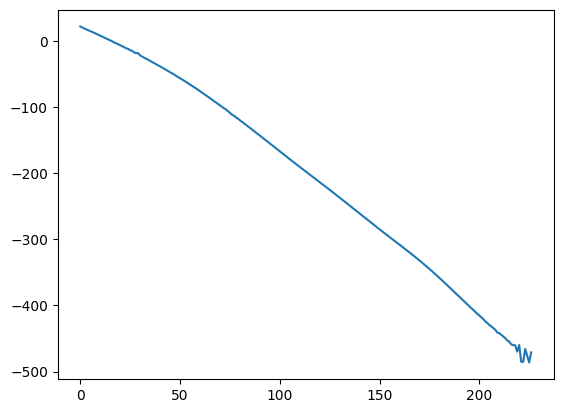

In [41]:
plt.plot(losses)